<a id='title'></a> 
# Описание проекта "Определение токсичных комментариев."

Требуется обучить модель классифицировать комментарии на позитивные и негативные. Имеется набор данных с разметкой о токсичности комментариев.

Требуется обеспечить значение метрики качества *F1* не меньше 0.75. 

## План работы над проектом.

Работу над проектом будем осуществлять в следующем порядке:

### Этап 1. Импорт библиотек, чтение и первичный анализ данных:

<a href='#1.1'>1.1. Импорт библиотек, чтение и первичный анализ данных.</a> 

### Этап 2. Подготовка данных:

<a href='#2.1'>2.1. Подготовка данных.</a> 

<a href='#2.1'>2.2. Разделение набора данных на выборки.</a> 

### Этап 3. Моделирование:

<a href='#3.1'>3.1. LogisticRegression.</a>

<a href='#3.2'>3.2. CatBoost.</a>

<a id='1.1'></a> 
# Этап 1. Импорт библиотек, чтение и первичный анализ данных.

Импортируем необходимые для работы библиотеки.

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
from nltk.stem import SnowballStemmer
import nltk
#nltk.download('stopwords') 
from nltk.corpus import stopwords 
from tqdm import notebook
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import parallel_backend
from tqdm import notebook
from random import randint
import matplotlib.pyplot as plt

Работа выполнялась в Google Colab, поэтому есть особенности загрузки данных через специальную библиотеку.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open('/content/drive/My Drive/toxic_comments.csv', 'r') as f:
    df = pd.read_csv(f)

Данные считаны. Выведем первые 5 строк данных.

In [4]:
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Изучим общую информацию о наборе данных.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посчитаем количество пропусков и дубликатов.

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

text     0
toxic    0
dtype: int64

# Вывод по этапу 1.

На данном этапе мы импортировали необходимые для работы библиотеки, считали набор данных и изучили его первые 5 строк. 

Набор данных содержит 2 поля: поле с комментарием (признаки модели) и поле с меткой о том, токсичный или не токсичный был комментарий (таргет).

В наборе данных содержится 159571 наблюдение, пропущенных значений и дубликатов в наборе данных нет.

Набор данных содержит исходную, непредобработанную информацию, которую нужно подготовить для использования в модели.

<a href='#title'>К оглавлению.</a> 

# Этап 2. Подготовка данных.

На данном этапе проведём подготовку данных к работе, а также сделаем разбиение набора данных на обучающую и тестовую выборки.

<a id='2.1'></a> 
## Этап 2.1. Подготовка данных.

Из этапа 1 мы выяснили, что данные представлены в сыром виде и не подвергнуты какой-либо предобработке: в данных есть символы пунктуации, цифры, никнеймы и прочая бесполезная информация.

Предобарботку совершим с помощью функции, которая будет работать с каждым отдельным комментарием. Сначала функция совершит стемминг с комментарием для приведения слов в комментарии к изначальной форме. Затем с помощью регулярных выражений мы очистим комментарий от цифр и служебных символов и знаков пунктуации (кроме ', который является смыслообразующим в английском языке). Затем избавимся от пробелов с помощью split, соединим заново предобработанные токены в предложение и приведём к формату Unicdoe.

In [8]:
english_stemmer = SnowballStemmer('english')
with parallel_backend('threading'):
    df['text_lemmatize'] = df['text'].apply(lambda x: ' '\
                                  .join(re.sub(r'[^a-z \']', ' ', 
                                  english_stemmer.stem(x)).split())).astype('U')

Проверим, всё ли получилось.

In [9]:
df.head(5)

,text,toxic,text_lemmatize
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Видим, что мы успешно подготовили данные к приемлемому для работы виду.

<a href='#title'>К оглавлению.</a> 

<a id='2.2'></a> 
## Этап 2.2.  Разделение набора данных на выборки.

На данном этапе разделим данные на выборки. 

Сначала определим признаки и таргер.

In [10]:
features = df['text_lemmatize']
target = df['toxic']

Разделим данные на train и test в соотношении 70% на 30%.

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.30, random_state=42)

Оценим важность каждого слова из выборок с помощью **TF-IDF**. Важность и смысл слова определяются его контекстом, поэтому при векторизации слов и оценке их важности будем использовать N-граммы в диапазоне от 1 слова до 5 слов.

Обучим эстиматор на тренировочной выборке, а потом с его помощью трансформируем обе выборки в векторы.

In [12]:
stop_words = list(set(stopwords.words('english'))) 
count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 5)) 
with parallel_backend('threading'):
    count_tf_idf.fit(features_train)
features_train = count_tf_idf.transform(features_train)
features_test = count_tf_idf.transform(features_test)

# Вывод по этапу 2.

На данном этапе мы преобработали данные, а также разделили их на обучающую и тестовую выборки.

Преобработка данных заключалась в переходе от исходного текста к тексту, пригодному для обучения и тестирования модели. Для этого мы использовали процедуру стемминга для перехода к исходной форме слова, регулярные выражения для очистки данных от лишней информации, а также split и join для перехода к конечной форме предложения без пробелов. 

Исходные данные были разделены на обучающую и тестовую выборки в соотношении 70% на 30%. 

Затем данные были преобразованы в векторый вид с помощью TF-IDF. Для оценки важности слов в контексте предложения были использованы N-граммы в диапазоне от 1 слова до 5 слов.

<a href='#title'>К оглавлению.</a> 

# Этап 3. Моделирование.

На данном этапе обучим и протестируем модели LogisticRegression и CatBoost.

<a id='3.1'></a> 
## Этап 3.1. LogisticRegression.

Исследуем модель LogisticRegression. 

Отмечу, что эстиматор TfidfVectorizer вернул нам гигантскую разреженную матрицу. Плюс LogisticRegression в том, что он может работать с разреженной матрицей, и её необязательно приводить в массив. 

Для подбора оптимальных гиперпараметров модели LogisticRegression будем использовать алгоритм GridSearchCV, оптимизировать будем параметр типа регуляризации (l1 или l2) и силы регуляризации (С). Для контроля эффекта переобучения будем использовать кросс-валидацию на 5 фолдах, для ускорения вычислений зададим параметру n_jobs значение -1, чтобы в расчёте участвовали все ядра машины.

In [13]:
model = LogisticRegression(random_state=42)
grid_params = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-3, 3, 10)}

gs_log_reg = GridSearchCV(model, grid_params, cv=5, scoring='f1', n_jobs=-1, 
                          verbose=10)
gs_log_reg.fit(features_train, target_train)
print('F1: {:.6f}'.format(gs_log_reg.best_score_))
print('Лучшие параметры:', gs_log_reg.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 70.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 84.9min finished


F1: 0.676798
Лучшие параметры: {'C': 1000.0, 'penalty': 'l2'}


Видим, что оптимального значения F1 в размере 0.676798 удалось достичь при следующих значениях гиперпараметров: тип регуляризации - l2, сила регуляризации - 1000.0.

Обучим модель на оптимальных значениях гиперпараметров и протестируем её на тестовых данных.

In [14]:
model = LogisticRegression(C=gs_log_reg.best_params_['C'], 
                           penalty=gs_log_reg.best_params_['penalty'], 
                           random_state=42)
model.fit(features_train, target_train)
pred = model.predict(features_test)
print('Метрика F1: {:.6f}'.format(f1_score(target_test, pred)))

Метрика F1: 0.779277


Модели LogisticRegression удалось достичь значения метрики F1 на уровне 0.779277, что соответствует условиям проекта в части значения метрики F1 не ниже 0.75, из чего следует, что построенная нами модель предсказывает эмоциональный окрас комментария на довольно хорошем уровне.

Протестируем нашу модель на адекватность.

Сравним результаты её работы с результатами работы случайно и константной моделей.

Изучим модель, которая будет генерировать случайный результат - негативный (1) или позитивный (0) комментарий.

In [15]:
pred = pd.Series([randint(0, 1) for i in range(len(target_test))], index=target_test.index)
print('F1 для случайной модели: {:.6f}'.format(f1_score(target_test, pred)))

F1 для случайной модели: 0.167150


Видим, что наша модель обеспечивает более точное предсказание эмоционального окраса комментария, чем случайная модель.

Посмотрим на константную модель.

Константая модель - модель, предсказывающая метку наиболее частого класса. Узнаем, какой это класс.

In [16]:
target_train.value_counts()

0    100341
1     11358
Name: toxic, dtype: int64

Видим, что наиболее частым классом является класс 0, то есть пользователи чаще позитивно отзываются о платформе, чем негативно.

Следовательно, константная модель должна предсказывать только метки с значением 0.

In [17]:
pred = pd.Series([0 for i in range(len(target_test))], index=target_test.index)
print('F1 для константной модели: {:.6f}'.format(f1_score(target_test, pred)))

F1 для константной модели: 0.000000


И снова наша модель обеспечивает лучшее по сравнению с константной моделью качество предсказания эмоционального окраса комментария.

<a href='#title'>К оглавлению.</a> 

<a id='3.2'></a> 
## Этап 3.2. CatBoostClassifier.

Протестируем модель CatBoostClassifier.

В отличие от LogisticRegression, CatBoostClassifier не умеет напрямую работать с разреженной матрицей. Внутри разреженная матрица преобразовывается к классической, и для хранения матрицы такого объёма нужно значительное количество оперативной памяти, что является довольно проблематичным моментом.

Для преодоления затруднения воспользуемся методом снижением размерности TruncatedSVD, известным как сингулярное разложение матрицы. Отмечу, что можно было бы применить и метод главных компонент PCA, однако PCA не работает с разреженными данными, в отличие от TruncatedSVD.

Перебирая его параметр n_components, можно узнать наиболее информативные признаки, которые обеспечивают высокое значение метрики F1.

Отмечу, что после 24 компонента ядро виртуальной среды падает, поэтому в рамках эксперимента остановимся на 24 компонентах.

В цикле будем постепенно обучать CatBoostClassifier, предварительно извлекая из исходной разреженной матрицы наиболее значимые компоненты - с 1 до 24.

Значения метрик F1, полученных в ходе эксперимента, будем складывать в список.

In [18]:
f1_list = []
for i in notebook.tqdm(range(1, 25)):
    with parallel_backend('threading'):
        decompose = TruncatedSVD(n_components=i, random_state=42)
        decompose.fit(features_train)
        features_train_decompose = decompose.transform(features_train)
        features_test_decompose = decompose.transform(features_test)
        model = CatBoostClassifier(eval_metric='F1', loss_function='Logloss', 
                                   random_state=42)
        model.fit(features_train_decompose, target_train, verbose=0)
        pred = model.predict(features_test_decompose)
        f1_list.append(f1_score(target_test, pred))

Визуализируем значения метрик.

По оси x отложим количество компонент, участвовавших в обучении, а по оси y - значения метрики F1 для каждого количества компонент.

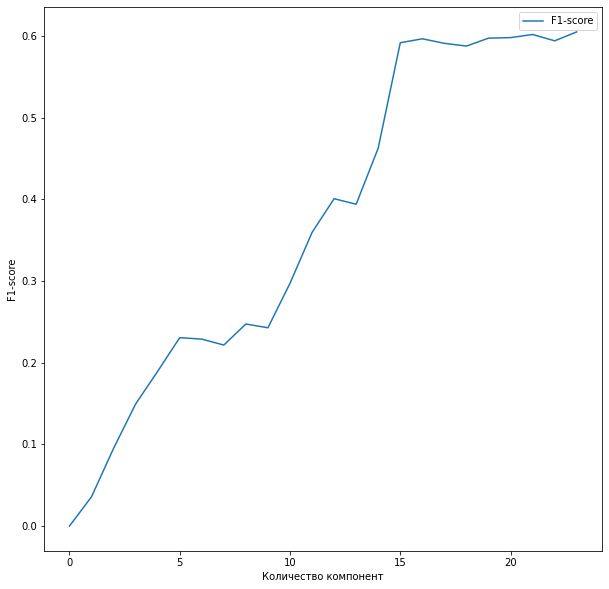

In [22]:
plt.figure(figsize=(10,10))
plt.plot(f1_list, label='F1-score')
plt.xlabel('Количество компонент')
plt.ylabel('F1-score')
plt.legend();

In [24]:
f1_df = pd.DataFrame({'n_comp' : [i for i in range(1, 25)], 'f1' : f1_list}).sort_values('f1', ascending=False)
f1_df.head(1)

,n_comp,f1
23,24,0.604998


Очевидно, что по мере увеличения числа компонент растёт и качество работы модели. Наибольшего качества модель достигает при количестве компонент, равном 24. Метрика F1 при таком количестве компонент составляет 0.604998. Очевидно, что мы рассмотрели лишь 24 признака из 11 201 201 и что по мере увеличения количество компонент в сингулярном разложении матрицы features_train, качество предсказания будет расти, однако текущие вычислительные мощности позволили исследовать только 24 компонента.

<a href='#title'>К оглавлению.</a> 

# Вывод по этапу 3.

На данном этапе мы протестировали модели LogisticRegression и CatBoostClassifier, подобрали оптимальные гиперпараметры для LogisticRegression с помощью GridSearchCV, а также применили технику сингулярного разложения матрицы для работы CatBoostClassifier.

По итогу исследования удалось получить следующие выводы:

1. Оптимальной для применения к задаче предсказания эмоционального окраса комментариев на платформе можно считать модель LogisticRegression с параметрами: тип регуляризации - l2, сила регуляризации - 1000.0. Данная модель обеспечила значение метрики F1 на уровне 0.779277 на тестовой выборке, что соответствует условиям проекта в части минимального значения метрики F1 на уровне 0.75. Оптимальная модель была проверена на адекватность путём сравнения метрики F1 для оптимальной модели с метриками F1 для константной модели и случайной модели. В обоих случаях оптимальная модель предсказывала эмоциональный окрас комментария лучше.


2. Для модели CatBoostClassifier исходная разреженная матрица была декомпозирована с помощью метода сингулярного разложения матрицы в диапазоне значений компонентов от 1 до 24. Оптимальным оказалось разложение матрицы до 24 компонент: при таком количестве компонент CatBoostClassifier обеспечил значение метрики F1 на уровне  0.604998. Очевидно, результат можно было бы улучшить, увеличив число компонент с 24 до, скажем, 50-60, однако имеющиеся вычислительные мощности не позволяют этого сделать на текущий момент.

<a href='#title'>К оглавлению.</a> 

# Итоговый вывод по проекту.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В рамках проекта требовалось научить модель классифицировать комментарии на позитивные и негативные. В распоряжении имелся набор данных с разметкой о токсичности правок.

Построенная модель должна была обеспечить значение метрики качества *F1* не меньше 0.75. 

Работа над проектом велась в следующем порядке:

1. Импорт библиотек, чтение и первичный анализ данных:


2. Подготовка данных:


3. Моделирование:

Отметим выводы, полученные в ходе работы над проектом.

# Вывод по этапу 1.

На данном этапе мы импортировали необходимые для работы библиотеки, считали набор данных и изучили его первые 5 строк. 

Набор данных содержит 2 поля: поле с комментарием (признаки модели) и поле с меткой о том, токсичный или не токсичный был комментарий (таргет).

В наборе данных содержится 159571 наблюдение, пропущенных значений и дубликатов в наборе данных нет.

Набор данных содержит исходную, непредобработанную информацию, которую нужно подготовить для использования в модели.

# Вывод по этапу 2.

На данном этапе мы преобработали данные, а также разделили их на обучающую и тестовую выборки.

Преобработка данных заключалась в переходе от исходного текста к тексту, пригодному для обучения и тестирования модели. Для этого мы использовали процедуру стемминга для перехода к исходной форме слова, регулярные выражения для очистки данных от лишней информации, а также split и join для перехода к конечной форме предложения без пробелов. 

Исходные данные были разделены на обучающую и тестовую выборки в соотношении 70% на 30%. 

Затем данные были преобразованы в векторый вид с помощью TF-IDF. Для оценки важности слов в контексте предложения были использованы N-граммы в диапазоне от 1 слова до 5 слов.

# Вывод по этапу 3.

На данном этапе мы протестировали модели LogisticRegression и CatBoostClassifier, подобрали оптимальные гиперпараметры для LogisticRegression с помощью GridSearchCV, а также применили технику сингулярного разложения матрицы для работы CatBoostClassifier.

По итогу исследования удалось получить следующие выводы:

1. Оптимальной для применения к задаче предсказания эмоционального окраса комментариев на платформе можно считать модель LogisticRegression с параметрами: тип регуляризации - l2, сила регуляризации - 1000.0. Данная модель обеспечила значение метрики F1 на уровне 0.779277 на тестовой выборке, что соответствует условиям проекта в части минимального значения метрики F1 на уровне 0.75. Оптимальная модель была проверена на адекватность путём сравнения метрики F1 для оптимальной модели с метриками F1 для константной модели и случайной модели. В обоих случаях оптимальная модель предсказывала эмоциональный окрас комментария лучше.


2. Для модели CatBoostClassifier исходная разреженная матрица была декомпозирована с помощью метода сингулярного разложения матрицы в диапазоне значений компонентов от 1 до 24. Оптимальным оказалось разложение матрицы до 24 компонент: при таком количестве компонент CatBoostClassifier обеспечил значение метрики F1 на уровне  0.604998. Очевидно, результат можно было бы улучшить, увеличив число компонент с 24 до, скажем, 50-60, однако имеющиеся вычислительные мощности не позволяют этого сделать на текущий момент.

<a href='#title'>К оглавлению.</a> 